# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. In particular, our model will be fed a text query and will return several images that are related to the query. To do this task, our model will be trained so that it embeds both image and text data into the same space, and importantly, encodes relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function. 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import tqdm
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [4]:
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
!pip install transformers
from transformers import BertModel, BertTokenizerFast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


## Encoders
Encoders denote the pretrained part of the network. In both image and text encoders, they returns an 1-D array. This is fed into fully connected layers having trainable parameters before computing the similarity. This FC layers will be defined separately, which we call Encoder Head. <br>
<br>
Encoder class must have
* Pretrained model and forward function.
* self.output_size: the size of the 1-D array. (This may be a tuple in the later step when we fine-tune the output of the language models.)
* self.num_parameters: This is not necessary but we store the number of pretrained parameters here.

In [7]:
class InceptionV3Encoder(torch.nn.Module):
    def __init__(self, embed_dim):
        super(InceptionV3Encoder, self).__init__()

        self.incep3 = torchvision.models.inception_v3(pretrained=True)
        self.incep3.aux_logits = False # We don't use the auxiliary output.
        self.output_size = self.incep3.fc.in_features # in_features=2048.
        self.incep3.fc = torch.nn.Identity() # Deactivate the fc layer. torch.nn.Identity has no parameters.
        for parameter in self.incep3.parameters():
            parameter.requires_grad = False # Freeze all the parameters.
        self.num_parameters = sum([np.prod(params.size()) for params in self.incep3.parameters()])

    def forward(self, x):
        return self.incep3(x)

class BertEncoder(torch.nn.Module):
    def __init__(self, embed_dim):
        super(BertEncoder, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions=False) # With bert-base-uncased, all the input are lowercased before being tokenized.
        self.output_size = self.bert.config.hidden_size # hidden_size=768.
        for parameter in self.bert.parameters():
            parameter.requires_grad = False # Freeze all the parameters.
        self.num_parameters = sum([np.prod(params.size()) for params in self.bert.parameters()])
    
    def forward(self, input_ids, attention_mask):
        last_hidden, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        return last_hidden[:, 0]

def Encoder(name, embed_dim=128):
    if name == "InceptionV3":
        return InceptionV3Encoder(embed_dim)
    elif name == "BERT":
        return BertEncoder(embed_dim)
    else:
        raise ValueError(name + " has not been implemented!")

## Encoder Head
Encoder Heads are defined as follows. While our Encoders have only pretrained parameters, which are freezed during the training, all the parameters in Encoder Heads are trainable. Usually, they consists of one or more fully connected layers. <br>
<br>
Encoder Head class must have
* Trainable model and forward function.
* self.num_parameters: This is not necessary but we store the number of trainable parameters here.

In [8]:
class EncoderHead1(torch.nn.Module):
    def __init__(self, input_dim, embed_dim=128):
        super(EncoderHead1, self).__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, embed_dim),
            torch.nn.Tanh()
        )
        self.num_parameters = sum([np.prod(params.size()) for params in self.fc.parameters()])

    def forward(self, x):
        return self.fc(x)

def EncoderHead(name, input_dim, embed_dim=128):
    if name == "normal_1":
        return EncoderHead1(input_dim, embed_dim)

## Preprocessors
The original dataset has lists of numbers and texts. To feed them into our Encoders, we need to preprocess them into the required form. This work is done by Preprocessors.

In [9]:
class ImagePreprocessor():
    def process(self, x):
        return torch.swapaxes(torch.swapaxes(x / 255.0, 3, 2), 2, 1)

class BertPreprocessor():
    def __init__(self, max_len=50):
        self.max_len = max_len
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", model_max_length=self.max_len)
    
    def process(self, x):
        padded_list = self.tokenizer.batch_encode_plus(x, padding=True)
        input_ids = torch.LongTensor(np.array(padded_list["input_ids"])) # It looks like bypassing numpy is faster.
        attention_mask = torch.LongTensor(np.array(padded_list["attention_mask"]))
        return input_ids, attention_mask

def Preprocessor(name, max_len=70):
    if name in ["InceptionV3"]:
        return ImagePreprocessor()
    elif name in ["BERT"]:
        return BertPreprocessor(max_len)
    else:
        raise ValueError(name + " has not been implemented!")

## Dataset 
To use the DataLoader, we need the following DualEncoderDataset class. It does
* Preprocess the data and store the output of Encoders.
* Create the positive and negative pairs of an image and a text.
* neg_rate controls the rate of negative pairs. For each positive pair, it generates neg_rate negative pairs.

In [10]:
class DualEncoderDataset(Dataset):
    def __init__(self, images, texts, device, image_model, text_model, embed_dim=128, max_len=70, neg_rate=4, preprocessing_batch_size=32):
        self.num_images = len(images)
        self.num_texts = len(texts)
        self.image_text_rate = int(self.num_texts / self.num_images)
        self.num_negative = int(self.num_texts * neg_rate)
        self.random_map = []
        self.shuffle()

        print("\nPreprocessing image data...")
        self.imagedata_preprocessed = []
        image_encoder = Encoder(image_model, embed_dim).to(device)
        image_preprocessor = Preprocessor(image_model)
        num_batches = math.ceil(self.num_images / preprocessing_batch_size)
        for i in tqdm.tqdm(range(num_batches)):
            if i < num_batches - 1:
                image_batch = images[i * preprocessing_batch_size : (i + 1) * preprocessing_batch_size]
            else:
                image_batch = images[i * preprocessing_batch_size :]
            image_batch = torch.FloatTensor(np.array(image_batch)).to(device)
            self.imagedata_preprocessed += image_encoder(image_preprocessor.process(image_batch)).tolist()
        self.image_encoder_num_parameters = image_encoder.num_parameters
        self.image_encoder_output_size = image_encoder.output_size

        print("Preprocessing text data...")
        self.textdata_preprocessed = []
        text_encoder = Encoder(text_model, embed_dim).to(device)
        text_preprocessor = Preprocessor(text_model, max_len)
        num_batches = math.ceil(self.num_texts / preprocessing_batch_size)
        for i in tqdm.tqdm(range(num_batches)):
            if i < num_batches - 1:
                text_batch = texts[i * preprocessing_batch_size : (i + 1) * preprocessing_batch_size]
            else:
                text_batch = texts[i * preprocessing_batch_size :]
            text_batch, attention_batch = text_preprocessor.process(text_batch)
            text_batch = text_batch.to(device)
            if attention_batch is not None:
                attention_batch = attention_batch.to(device)
                self.textdata_preprocessed += text_encoder(text_batch, attention_batch).tolist()
            else:
                self.textdata_preprocessed += text_encoder(text_batch).tolist()
        self.text_encoder_num_parameters = text_encoder.num_parameters
        self.text_encoder_output_size = text_encoder.output_size

    def shuffle(self):
        self.random_map = np.random.randint(0, self.num_texts - self.image_text_rate, self.num_negative)
        for i in range(self.num_negative):
            if self.random_map[i] >= i % self.num_texts // self.image_text_rate * self.image_text_rate:
                self.random_map[i] += self.image_text_rate
    
    def set_neg_rate(self, neg_rate):
        self.num_negative = int(self.num_texts * neg_rate)
        self.random_map = []
        self.shuffle()
    
    def print_num_params(self):
        print(f"\n=== Image Encoder ===")
        print(f"  Pretrained Parameters: {self.image_encoder_num_parameters:,}")
        print(f"\n=== Text Encoder ===")
        print(f"  Pretrained Parameters: {self.text_encoder_num_parameters:,}")
    
    def __len__(self):
        return self.num_texts + self.num_negative

    def __getitem__(self, sample_idx):
        if torch.is_tensor(sample_idx):
            sample_idx = sample_idx[0].tolist()
        image_idx = sample_idx % self.num_texts // self.image_text_rate
        image = self.imagedata_preprocessed[image_idx]
        image = torch.from_numpy(np.array(image)).to(torch.float32)

        if sample_idx < self.num_texts:
            text_idx = sample_idx
        else:
            text_idx = self.random_map[sample_idx - self.num_texts]
        text = self.textdata_preprocessed[text_idx]
        text = torch.from_numpy(np.array(text)).to(torch.float32)
        
        label = 1 if sample_idx < self.num_texts else -1
        label = torch.from_numpy(np.array(label)).to(torch.float32)

        sample = {"images": image, "texts": text, "labels": label, "image_idx": image_idx, "text_idx": text_idx}
        return sample

## Constructing Dataset
Set the parameters; embed_dim is the dimensionality of the embedding space, and max_len is the maximum length of the encoded text sequence. It takes time to construct the dataset because preprocessing and feed forwarding the pretrained nets are performed.

In [11]:
embed_dim = 100
max_len = 70
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "normal_1"
text_head_model = "normal_1"

TrainingDataset = DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model,
                                     embed_dim=embed_dim, max_len=max_len, neg_rate=2)
TestDataset = DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, 
                                 embed_dim=embed_dim, max_len=max_len, neg_rate=2)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 99/99 [00:17<00:00,  5.74it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 985/985 [00:50<00:00, 19.39it/s]




=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240

Preprocessing image data...


100%|██████████| 43/43 [00:06<00:00,  6.83it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:21<00:00, 19.47it/s]


## Encoder Heads, Loss Function, Optimizer
Recall that all the trainable parameters reside in Encoder Heads. We also set the loss function and optimizer for each Encoder Head.

In [25]:
image_head = EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,100,388

=== Text Encoder Head ===
  Trainable Parameters: 445,028


## Training Function
Training and evaluation functions. As we set the CosineEmbeddingLoss with reduction="sum", all the loss are aggregated and divided by the number of samples at the end. <br>
With our naive algorithm to compute the Median Rank (MedR) and Recall at top K (R@K), it takes time to evaluate them. By setting only_loss=True, which is the default setting, we can skip the heavy load of computing MedR and R@K. <br>
sim_mat stores the cosine similarity between all the image-text pairs. It has a shape (# images * # texts).

In [26]:
def train():
    image_head.train()
    text_head.train()
    train_loss = 0
    num_samples = 0

    for batch in trainloader:
        image_optimizer.zero_grad()
        text_optimizer.zero_grad()
        image_embedding = image_head(batch["images"].to(device))
        text_embedding = text_head(batch["texts"].to(device))
        loss = criterion(image_embedding, text_embedding, batch["labels"].to(device))
        loss.backward()
        image_optimizer.step()
        text_optimizer.step()
        train_loss += loss.item()
        num_samples += batch["labels"].size(0)
    
    train_loss /= num_samples
    return train_loss

def eval(only_loss=True, K=10):
    image_head.eval()
    text_head.eval()
    eval_loss = 0
    num_samples = 0
    image_embeddings = [None for _ in range(TestDataset.num_images)]
    text_embeddings = [None for _ in range(TestDataset.num_texts)]
    with torch.no_grad():
        for batch in testloader:
            image_embedding = image_head(batch["images"].to(device))
            text_embedding = text_head(batch["texts"].to(device))
            for i in range(len(batch["image_idx"])):
                if image_embeddings[batch["image_idx"][i]] is None:
                    image_embedding_numpy = image_embedding[i].cpu().numpy()
                    image_embeddings[batch["image_idx"][i]] = image_embedding_numpy / np.linalg.norm(image_embedding_numpy, ord=2)
            for i in range(len(batch["text_idx"])):
                if text_embeddings[batch["text_idx"][i]] is None:
                    text_embedding_numpy = text_embedding[i].cpu().numpy()
                    text_embeddings[batch["text_idx"][i]] = text_embedding_numpy / np.linalg.norm(text_embedding_numpy, ord=2)
            loss = criterion(image_embedding, text_embedding, batch["labels"].to(device))
            eval_loss += loss.item()
            num_samples += batch["labels"].size(0)
    eval_loss /= num_samples

    sim_mat = np.zeros((TestDataset.num_images, TestDataset.num_texts))
    if only_loss:
        MedR = None
        RatK = None
    else: # Even with our small dataset, computing similarity between all the image-text pairs takes about 5 minutes.
        for i in range(TestDataset.num_images):
            for j in range(TestDataset.num_texts):
                sim_mat[i][j] = sum(image_embeddings[i] * text_embeddings[j])
        rank = np.argsort(-sim_mat, axis=0)
        ranking = np.array([rank[i // TestDataset.image_text_rate, i] for i in range(TestDataset.num_texts)])
        MedR = np.median(ranking)
        RatK = sum(ranking < K) / len(ranking)
    return eval_loss, MedR, RatK, sim_mat

In [27]:
epochs = 20
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False)

print("Start Training...")
for epoch in range(epochs):
    trainloss = train()
    train_loss.append(trainloss)
    evalloss, _, _, _ = eval()
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print("Epoch: " + str(epoch + 1) + " | Training loss: " + str(round(trainloss, 4)) + " | Test loss: " + str(round(evalloss, 4)))
    # if (epoch + 1) % 4 == 0:
    #     TrainingDataset.shuffle()
    #     trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
    #     print("   Negative pairs shuffled after epoch " + str(epoch + 1))
_, MedR, RatK, sim_mat = eval(only_loss=False)

Start Training...
Epoch: 2 | Training loss: 0.1548 | Test loss: 0.1904
Epoch: 4 | Training loss: 0.1125 | Test loss: 0.1828
Epoch: 6 | Training loss: 0.0988 | Test loss: 0.1792
Epoch: 8 | Training loss: 0.0897 | Test loss: 0.1733
Epoch: 10 | Training loss: 0.0829 | Test loss: 0.1667
Epoch: 12 | Training loss: 0.0779 | Test loss: 0.1693
Epoch: 14 | Training loss: 0.0742 | Test loss: 0.1638
Epoch: 16 | Training loss: 0.071 | Test loss: 0.1632
Epoch: 18 | Training loss: 0.0686 | Test loss: 0.1605
Epoch: 20 | Training loss: 0.0664 | Test loss: 0.1634


Ideally in the heatmap, we want to have high values in diagonal entries and values less than margin (a parameter in CosineEmbeddingLoss) otherwise.

Median Rank: 669.0
Recall at K: 0.01


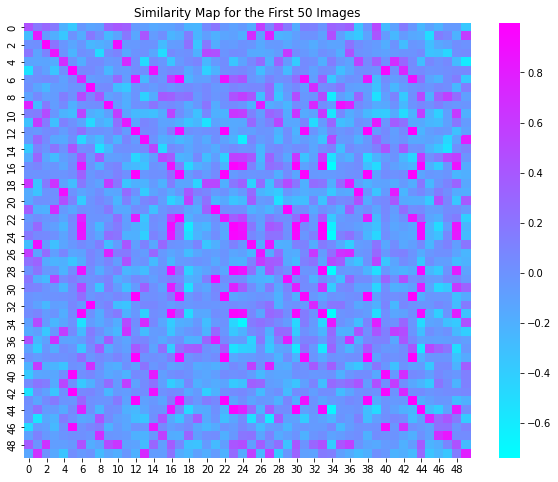

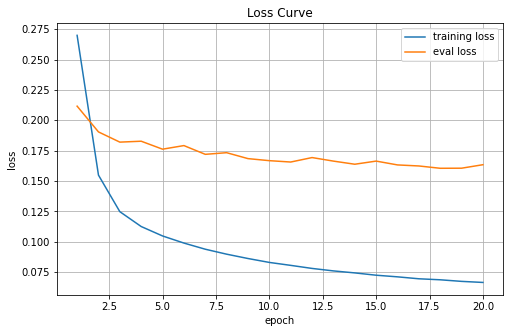

In [49]:
print("Median Rank: " + str(round(MedR, 2)))
print("Recall at K: " + str(round(RatK, 2)))

num_show = 50
plt.figure(figsize=(10,8))
rand_idx = np.random.randint(0, len(sim_mat), num_show)
sns.heatmap(sim_mat[rand_idx][:, rand_idx * 10 + np.random.randint(0, 10, 1)], cmap="cool")
plt.title("Similarity Map for the First " + str(num_show) + " Images")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label="training loss")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="eval loss")
plt.title("Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()